<a href="https://colab.research.google.com/github/Ssurf777/VAEforPointCloud/blob/main/main_for_MoGVAE_v2_(MSE)_%E5%8F%AF%E8%A6%96%E5%8C%96.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install POT

In [2]:
import requests
import os

def download_file(url, local_filename):
    """Downloads a file from a URL to a local file."""
    print(f"Downloading {url}...")
    try:
        with requests.get(url, stream=True) as r:
            r.raise_for_status()
            with open(local_filename, 'wb') as f:
                for chunk in r.iter_content(chunk_size=4096):  # Smaller chunk size
                    f.write(chunk)
        print(f"{local_filename} downloaded successfully.")
    except requests.exceptions.RequestException as e:
        print(f"Failed to download {local_filename}: {e}")

# URLs for downloading
urls = {
    "utils.py": "https://raw.githubusercontent.com/Ssurf777/VAEforPointCloud/main/lib/utils.py",
    "file_io.py": "https://raw.githubusercontent.com/Ssurf777/VAEforPointCloud/main/lib/file_io.py",
    "point_cloud.py": "https://raw.githubusercontent.com/Ssurf777/VAEforPointCloud/main/lib/point_cloud.py",
    "sampling.py": "https://raw.githubusercontent.com/Ssurf777/VAEforPointCloud/main/lib/sampling.py",
    "vae_models.py": "https://raw.githubusercontent.com/Ssurf777/VAEforPointCloud/main/lib/vae_models.py",
    "ChamferDis.py": "https://raw.githubusercontent.com/Ssurf777/VAEforPointCloud/main/lib/ChamferDis.py",
    "EarthMoversDis.py": "https://raw.githubusercontent.com/Ssurf777/VAEforPointCloud/main/lib/EarthMoversDis.py",
    "train.py": "https://raw.githubusercontent.com/Ssurf777/VAEforPointCloud/main/lib/train.py",
    "visualize_loss.py": "https://raw.githubusercontent.com/Ssurf777/VAEforPointCloud/main/lib/visualize_loss.py",
    "Dataloader.py": "https://raw.githubusercontent.com/Ssurf777/VAEforPointCloud/main/lib/Dataloader.py",
    "mogvae_v2_models.py": "https://raw.githubusercontent.com/Ssurf777/VAEforPointCloud/main/lib/mogvae_v2_models.py",
}

# Download each file
for local_filename, url in urls.items():
    download_file(url, local_filename)



utils.py downloaded successfully.
file_io.py downloaded successfully.
point_cloud.py downloaded successfully.
sampling.py downloaded successfully.
Failed to download vae_models.py: 404 Client Error: Not Found for url: https://raw.githubusercontent.com/Ssurf777/VAEforPointCloud/main/lib/vae_models.py
ChamferDis.py downloaded successfully.
EarthMoversDis.py downloaded successfully.
train.py downloaded successfully.
visualize_loss.py downloaded successfully.
Dataloader.py downloaded successfully.
mogvae_v2_models.py downloaded successfully.


In [3]:

# Import downloaded modules
import utils
import file_io
import point_cloud
import sampling
import ChamferDis
import EarthMoversDis
import train
import Dataloader
import visualize_loss
import mogvae_v2_models
from utils import get_available_memory
from file_io import read_off
from point_cloud import pcshow
from sampling import PointSampler
from ChamferDis import chamfer_distance
from EarthMoversDis import emd_distance
from train import train
from visualize_loss import visualize_loss
from Dataloader import prepare_data_for_ISAB
from mogvae_v2_models import MoGVAE

available_memory_gb = get_available_memory()
print(f"Available memory: {available_memory_gb:.2f} GB")

Available memory: 11.03 GB


In [4]:
import torch
import torch.optim as optim
import numpy as np



device = 'cuda' if torch.cuda.is_available() else 'cpu'
num_points =5000
# データ準備
file_names = [f"/content/drive/MyDrive/chair/chair_{i:04d}.off" for i in range(1, 10)]
data_loader = prepare_data_for_ISAB(file_names, num_points=num_points, device=device)
print(len(data_loader))

9


In [5]:

# ---------------- Training Loop ----------------

# ハイパーパラメータ設定
epochs = 5000
interval = 100

# モデル、オプティマイザ、デバイスなどの設定（例）
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
num_points = 5000
n_z = 3  # 潜在次元
model = MoGVAE(num_points=5000, n_z=3, n_components=2).to(device)


In [6]:
model.load_state_dict(torch.load('/content/drive/MyDrive/chair/MoGVAE_Np5000_MSE2_0224.pth', map_location=device))

<All keys matched successfully>

In [7]:
model

MoGVAE(
  (conv1): Conv1d(3, 64, kernel_size=(1,), stride=(1,))
  (conv2): Conv1d(64, 128, kernel_size=(1,), stride=(1,))
  (conv3): Conv1d(128, 1024, kernel_size=(1,), stride=(1,))
  (maxpool): AdaptiveMaxPool1d(output_size=1)
  (linear1): Linear(in_features=1024, out_features=512, bias=True)
  (linear2): Linear(in_features=512, out_features=256, bias=True)
  (linear3): Linear(in_features=256, out_features=9, bias=True)
  (enc_mu): Linear(in_features=9, out_features=6, bias=True)
  (enc_logvar): Linear(in_features=9, out_features=6, bias=True)
  (enc_pi): Linear(in_features=9, out_features=2, bias=True)
  (dec1): Linear(in_features=3, out_features=1024, bias=True)
  (dec2): Linear(in_features=1024, out_features=512, bias=True)
  (dconv1): ConvTranspose1d(512, 1024, kernel_size=(1,), stride=(1,))
  (dconv2): ConvTranspose1d(1024, 2048, kernel_size=(1,), stride=(1,))
  (dec3): Linear(in_features=2048, out_features=15000, bias=True)
)

In [21]:
import numpy as np
import torch

z_list_final = []

model.eval()

with torch.no_grad():
    for i, data in enumerate(data_loader):
        # 点群が data[0] に格納されていると仮定（例: data = (pointcloud,)）
        if isinstance(data, (list, tuple)):
            inputs = data[0].to(device)
        else:
            inputs = data.to(device)

        _, z = model(inputs)  # 再構成結果は不要、z だけ使う

        # z: (B, 3) → 各形状1件ずつなので B=1、z.squeeze()で (3,) に
        z_np = z.squeeze().cpu().detach().numpy()

        z_list_final.append(z_np)

# 最終的に (9, 3) になるはず
z_list_final_np = np.stack(z_list_final, axis=0)
np.save('z_list_final.npy', z_list_final_np)


In [22]:
z_list_final_np.shape

(9, 3)

In [23]:
print(z_list_final_np) # z mu logvar

[[ 0.73644435 -0.33892065 -2.3677566 ]
 [ 2.065445    1.0290976  -0.58702195]
 [ 0.89795095 -1.3510611  -1.4747589 ]
 [ 1.7231897  -0.12125026 -1.0212353 ]
 [ 1.3486915  -0.7547887  -1.3726281 ]
 [ 1.7140586  -0.91651905  0.21298026]
 [ 1.1285797  -1.951439   -0.88972133]
 [ 1.1559675   0.88365316 -1.85592   ]
 [ 1.5873598  -1.6110446  -0.56275594]]


# 再構成形状の可視化

torch.Size([1, 5000, 3])
torch.Size([1, 5000, 3])
torch.Size([1, 5000, 3])
torch.Size([1, 5000, 3])
torch.Size([1, 5000, 3])
torch.Size([1, 5000, 3])
torch.Size([1, 5000, 3])
torch.Size([1, 5000, 3])
torch.Size([1, 5000, 3])


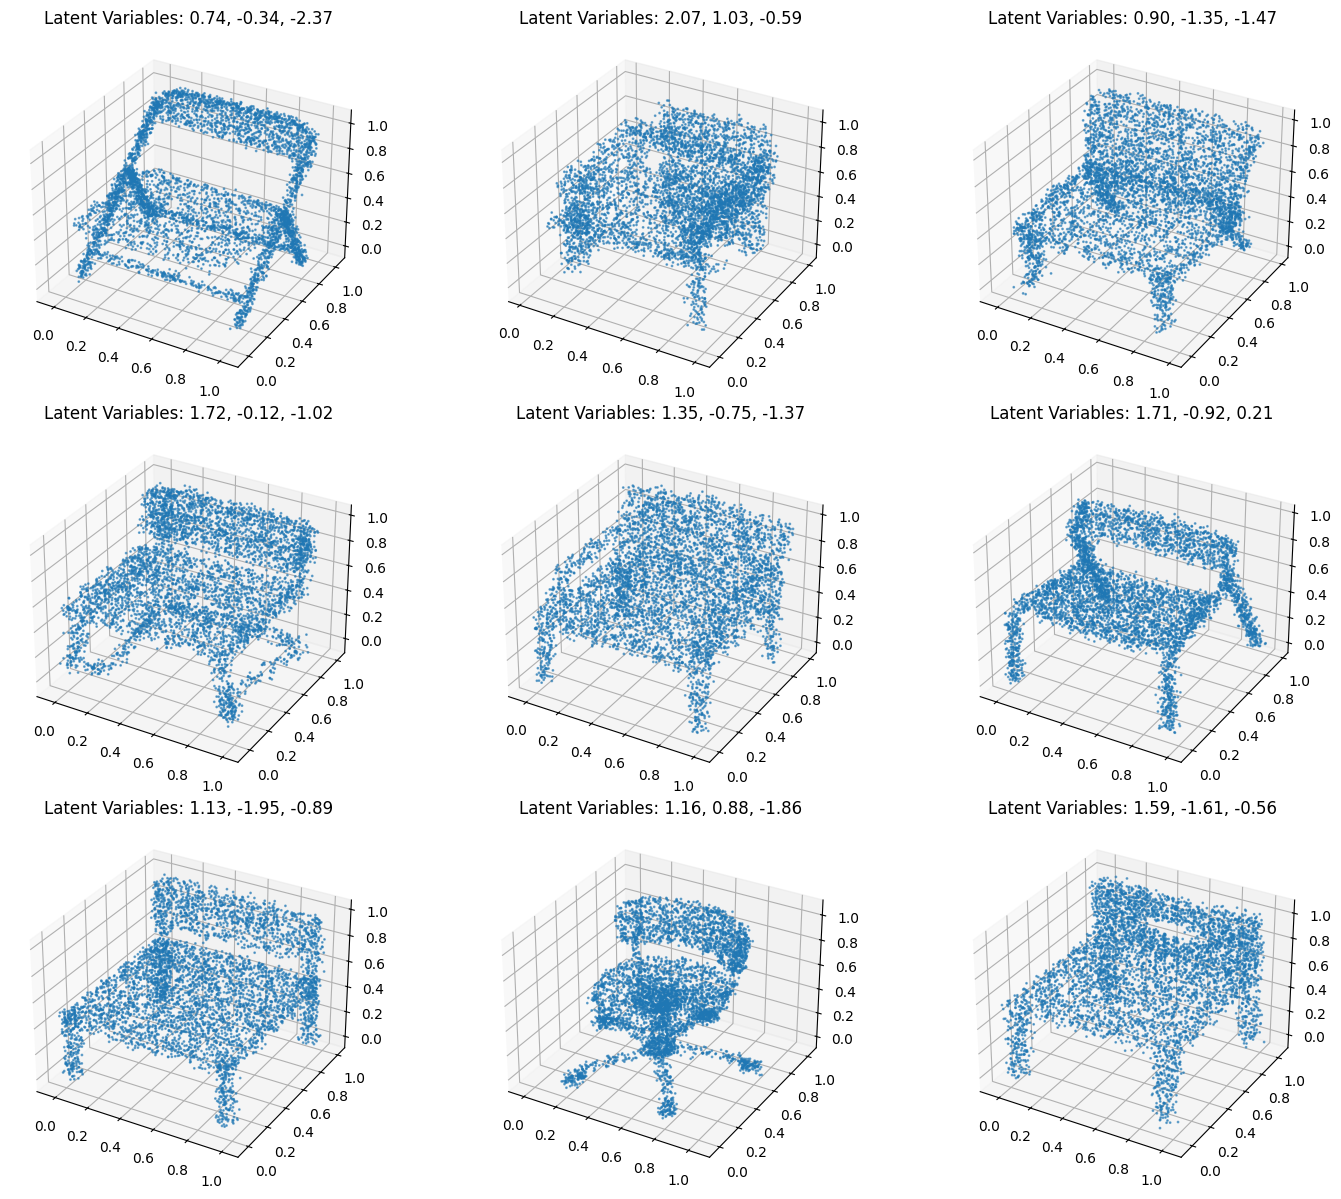

In [25]:
import torch
import numpy as np
import matplotlib.pyplot as plt

# z_list_final.npy を読み込んで z_list に変換
z_array = np.load("z_list_final.npy")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
z_list = [torch.tensor(z_array[i], dtype=torch.float32).to(device) for i in range(z_array.shape[0])]

# 可視化用設定
num_points = 5000
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(15, 12), subplot_kw={'projection': '3d'})
axes = axes.flatten()

# 再構成と可視化
for index, z in enumerate(z_list):
    if index >= len(axes):
        break  # 9つのプロットで終了

    # 再構築 (z を 1バッチの形に変換して decode)
    z_input = z.unsqueeze(0)  # shape: (1, 3)
    recon_batch = model.decode(z_input)

    #recon_batch = model.decode(z)  # z をバッチの形状に変換
    print(recon_batch.shape)

    # CPU上で detach して numpy に変換
    # デコード結果 recon_batch: (1, num_points, 3)
    reconst_np = recon_batch.squeeze(0).cpu().detach().numpy()  # -> (num_points, 3)

    # 各軸を列インデックスで取得
    reconst_x = reconst_np[:, 0]
    reconst_y = reconst_np[:, 1]
    reconst_z = reconst_np[:, 2]

    # プロット
    axes[index].scatter(reconst_x, reconst_y, reconst_z, s=1, alpha=0.6)

    # 潜在変数の値をフラット化してタイトルに表示
    z_flat = z.view(-1).tolist()  # 1次元化
    z_str = ", ".join([f"{value:.2f}" for value in z_flat])
    axes[index].set_title(f"Latent Variables: {z_str}")

# 最後にプロットを表示
plt.tight_layout()
plt.show()


# Latent Space変化アニメ

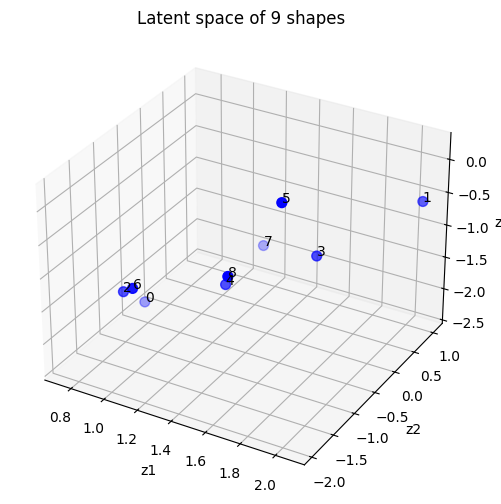

In [27]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np

z_array = np.load('z_list_final.npy')  # shape (9, 3)

fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(z_array[:, 0], z_array[:, 1], z_array[:, 2], c='blue', s=50)

for i, (x, y, z) in enumerate(z_array):
    ax.text(x, y, z, f'{i}', color='black', fontsize=10)

ax.set_xlabel('z1')
ax.set_ylabel('z2')
ax.set_zlabel('z3')
plt.title('Latent space of 9 shapes')
plt.show()


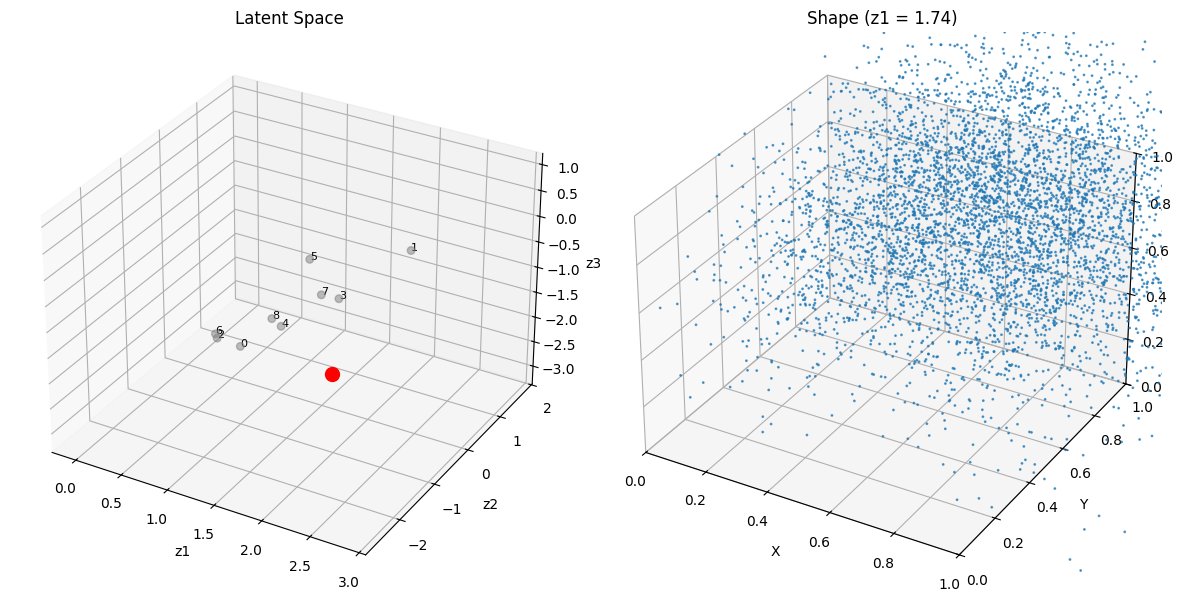

In [32]:
import torch
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.animation import FuncAnimation
import numpy as np
from matplotlib.animation import PillowWriter

# 潜在変数データ
z_array = np.load('z_list_final.npy')  # shape: (9, 3)
target_index = 0
base_z = z_array[target_index].copy()

# z1軸を変化させる範囲とフレーム数
num_frames = 21
z1_range = np.linspace(base_z[0] - 1.0, base_z[0] + 1.0, num_frames)

# 潜在空間の軸範囲（固定化）
z1_min, z1_max = np.min(z_array[:, 0]) - 1, np.max(z_array[:, 0]) + 1
z2_min, z2_max = np.min(z_array[:, 1]) - 1, np.max(z_array[:, 1]) + 1
z3_min, z3_max = np.min(z_array[:, 2]) - 1, np.max(z_array[:, 2]) + 1

# 初期化
fig = plt.figure(figsize=(12, 6))
ax1 = fig.add_subplot(121, projection='3d')  # 潜在空間
ax2 = fig.add_subplot(122, projection='3d')  # 再構成形状

def update(frame):
    ax1.cla()
    ax2.cla()

    current_z = base_z.copy()
    current_z[0] = z1_range[frame]

    # 潜在空間のプロット
    ax1.scatter(z_array[:, 0], z_array[:, 1], z_array[:, 2], c='gray', s=30, alpha=0.5)
    ax1.scatter(current_z[0], current_z[1], current_z[2], c='red', s=100)
    for i, (x, y, z) in enumerate(z_array):
        ax1.text(x, y, z, f'{i}', color='black', fontsize=8)

    ax1.set_title("Latent Space")
    ax1.set_xlabel('z1')
    ax1.set_ylabel('z2')
    ax1.set_zlabel('z3')
    ax1.set_xlim([z1_min, z1_max])
    ax1.set_ylim([z2_min, z2_max])
    ax1.set_zlim([z3_min, z3_max])

    # 再構成形状の描画
    z_tensor = torch.tensor(current_z, dtype=torch.float32).unsqueeze(0).to(device)
    with torch.no_grad():
        pointcloud = model.decode(z_tensor).squeeze(0).cpu().numpy()  # (5000, 3)

    ax2.scatter(pointcloud[:, 0], pointcloud[:, 1], pointcloud[:, 2], s=1, alpha=0.7)
    ax2.set_title(f"Shape (z1 = {current_z[0]:.2f})")
    ax2.set_xlim([0, 1])
    ax2.set_ylim([0, 1])
    ax2.set_zlim([0, 1])
    ax2.set_xlabel('X')
    ax2.set_ylabel('Y')
    ax2.set_zlabel('Z')

# アニメーションの実行・保持
# メタデータで loop を指定する
metadata = {'loop': 0}
writer = PillowWriter(fps=5, metadata=metadata)

ani = FuncAnimation(fig, update, frames=num_frames, interval=300)

# 保存（GIF + 無限ループ）
ani.save("latent_transition.gif", writer=writer)

#ani = FuncAnimation(fig, update, frames=num_frames, interval=300)
plt.tight_layout()
plt.show()


In [34]:
import torch
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.animation import FuncAnimation, PillowWriter
import numpy as np

# 潜在ベクトル
z_array = np.load('z_list_final.npy')  # (9, 3)
z0 = z_array[0]
z1 = z_array[1]

# 補間ステップ
num_frames = 51
ts = np.linspace(0, 1, num_frames)

# 潜在空間の軸範囲
z1_min, z1_max = np.min(z_array[:, 0]) - 1, np.max(z_array[:, 0]) + 1
z2_min, z2_max = np.min(z_array[:, 1]) - 1, np.max(z_array[:, 1]) + 1
z3_min, z3_max = np.min(z_array[:, 2]) - 1, np.max(z_array[:, 2]) + 1

# Figure 初期化
fig = plt.figure(figsize=(12, 6))
ax1 = fig.add_subplot(121, projection='3d')
ax2 = fig.add_subplot(122, projection='3d')

def update(frame):
    ax1.cla()
    ax2.cla()

    t = ts[frame]
    z_interp = (1 - t) * z0 + t * z1

    # 潜在空間の描画
    ax1.scatter(z_array[:, 0], z_array[:, 1], z_array[:, 2], c='gray', s=30, alpha=0.5)
    ax1.plot([z0[0], z1[0]], [z0[1], z1[1]], [z0[2], z1[2]], c='green', linestyle='--')
    ax1.scatter(z_interp[0], z_interp[1], z_interp[2], c='red', s=100)
    for i, (x, y, z) in enumerate(z_array):
        ax1.text(x, y, z, f'{i}', color='black', fontsize=8)

    ax1.set_title(f"Latent Interpolation t={t:.2f}")
    ax1.set_xlabel('z1')
    ax1.set_ylabel('z2')
    ax1.set_zlabel('z3')
    ax1.set_xlim([z1_min, z1_max])
    ax1.set_ylim([z2_min, z2_max])
    ax1.set_zlim([z3_min, z3_max])

    # decodeして形状再構成
    z_tensor = torch.tensor(z_interp, dtype=torch.float32).unsqueeze(0).to(device)
    with torch.no_grad():
        pointcloud = model.decode(z_tensor).squeeze(0).cpu().numpy()

    ax2.scatter(pointcloud[:, 0], pointcloud[:, 1], pointcloud[:, 2], s=1, alpha=0.7)
    ax2.set_xlim([0, 1])
    ax2.set_ylim([0, 1])
    ax2.set_zlim([0, 1])
    ax2.set_title(f"Interpolated Shape (t = {t:.2f})")
    ax2.set_xlabel('X')
    ax2.set_ylabel('Y')
    ax2.set_zlabel('Z')

# アニメーション作成 & 保存
ani = FuncAnimation(fig, update, frames=num_frames, interval=300)

# 無限ループGIFとして保存
metadata = {'loop': 0}
writer = PillowWriter(fps=5, metadata=metadata)
ani.save("interpolation_0_to_1.gif", writer=writer)
plt.close()


# 再構成誤差チェック using CD

In [ ]:
import torch
from torch.utils.data import DataLoader, TensorDataset
reconstructed_point_cloud=[]
# Chamfer Distanceの計算
chamfer_distances = []
for i, (x,) in enumerate(data_loader):
    x = x.to(device)
    x = x.squeeze(0)

    # Decode z_list[i]
    #z = torch.tensor(z_list[i]).to(device)
    recon_batch = model.decode(z_list[i])
    # CPU上で detach して numpy に変換
    reconst_np = recon_batch.squeeze(0).cpu().detach().numpy()  # -> (num_points, 3)

    # 各軸を列インデックスで取得し、Tensor に変換
    reconst_x = torch.from_numpy(reconst_np[:, 0])
    reconst_y = torch.from_numpy(reconst_np[:, 1])
    reconst_z = torch.from_numpy(reconst_np[:, 2])

    # Tensor を stack して reconstructed_point_cloud を作成
    reconstructed_point_cloud = torch.stack([reconst_x, reconst_y, reconst_z], dim=-1).unsqueeze(0).to(device)


    # 元の点群の形状を整える
    original_point_cloud = x.reshape(1, num_points, 3).to(device)

    # カスタム関数でChamfer Distanceを計算
    loss_cd = chamfer_distance(original_point_cloud, reconstructed_point_cloud)
    chamfer_distances.append(loss_cd.item())

# Chamfer距離を出力
print("Chamfer Distances:", chamfer_distances)
average_chamfer_distance = sum(chamfer_distances) / len(chamfer_distances)
print(f"Average Chamfer Distance: {average_chamfer_distance}")

import matplotlib.pyplot as plt

# Chamfer Distancesの棒グラフをプロット
plt.figure(figsize=(12, 6))
plt.bar(range(len(chamfer_distances)), chamfer_distances, color='skyblue', label='Chamfer Distance')
plt.axhline(y=average_chamfer_distance, color='r', linestyle='--', label='Average Chamfer Distance')

# グラフの装飾
plt.title('Chamfer Distance for Each Sample')
plt.xlabel('Sample Index')
plt.ylabel('Chamfer Distance')
plt.xticks(range(len(chamfer_distances)))
plt.legend()
plt.grid(True)
plt.show()


# 再構成誤差チェック using EMD

In [ ]:
import torch
import ot  # Optimal Transportライブラリ
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt

# EMDの計算
emd_distances = []
reconstructed_point_cloud=[]
for i, (x,) in enumerate(data_loader):
    x = x.to(device)
    x = x.squeeze(0)

    # Decode z_list[i]
    #z = torch.tensor(z_list[i]).to(device)
    recon_batch = model.decode(z_list[i])
    # CPU上で detach して numpy に変換
    reconst_np = recon_batch.squeeze(0).cpu().detach().numpy()  # -> (num_points, 3)

    # 各軸を列インデックスで取得し、Tensor に変換
    reconst_x = torch.from_numpy(reconst_np[:, 0])
    reconst_y = torch.from_numpy(reconst_np[:, 1])
    reconst_z = torch.from_numpy(reconst_np[:, 2])

    # Tensor を stack して reconstructed_point_cloud を作成
    reconstructed_point_cloud = torch.stack([reconst_x, reconst_y, reconst_z], dim=-1).unsqueeze(0).to(device)
    reconstructed_point_cloud = reconstructed_point_cloud.reshape(num_points, 3).to(device)


    # 元の点群の形状を整える
    original_point_cloud = x.reshape(num_points, 3).to(device)

    # カスタム関数でEMDを計算
    loss_emd = emd_distance(original_point_cloud, reconstructed_point_cloud)
    emd_distances.append(loss_emd)

# EMDの結果を出力
print("EMD Distances:", emd_distances)
average_emd_distance = sum(emd_distances) / len(emd_distances)
print(f"Average EMD Distance: {average_emd_distance}")

# EMDの棒グラフをプロット
plt.figure(figsize=(12, 6))
plt.bar(range(len(emd_distances)), emd_distances, color='lightcoral', label='EMD Distance')
plt.axhline(y=average_emd_distance, color='r', linestyle='--', label='Average EMD Distance')

# グラフの装飾
plt.title('Earth Mover’s Distance for Each Sample')
plt.xlabel('Sample Index')
plt.ylabel('EMD Distance')
plt.xticks(range(len(emd_distances)))
plt.legend()
plt.grid(True)
plt.show()
